# NLMFE in practice

This notebook aims at introducing the nlmfe package implementing the FPMLE and FPMLE$^{++}$ algorithms developed in Mugnier and Wang (2022, WP).

In [1]:
from nlmfe.TwoWayFPMLE import TwoWayFPMLE
from nlmfe.BiasCorrections import BiasCorrections
help(TwoWayFPMLE)

Help on class TwoWayFPMLE in module nlmfe.TwoWayFPMLE:

class TwoWayFPMLE(builtins.object)
 |  TwoWayFPMLE(A, b, indiv_ref=0, het_exog=None, model='logit', max_workers=4, solver='Newton-CG', options_set={'xtol': 1e-06, 'maxiter': 1000, 'disp': False}, verbose=True)
 |  
 |  TwoWayFPMLE:
 |      This class implements fast Gauss-Seidel fixed-point algorithms (FPMLE 
 |      and FPMLE++) for estimating semiparametric nonlinear panel data models 
 |      with two-way fixed effects as described in Mugnier & Wang (2022, 
 |      Working Paper) -- ``Identification and (Fast) Estimation of Large 
 |      Nonlinear Panel Models with Two-Way Fixed Effects''. 
 |      The implementation is as described in the paper. Notation attempts to 
 |      follow that used in the paper. 
 |      In particular: 
 |      `N'  : number of individuals;
 |      `T'  : number of time periods (must be balanced);
 |      `K'  : number of observed covariates.
 |      Missing cells in unbalanced panel data can be imp

## Application to simulated data

In [2]:
import numpy as np

def logit_cdf(x):
    """
    logit_cdf:
        evaluate the logistic cumulative distribution function (cdf) at point x.
        
    :param x: evaluation point
    """
    return 1. / (1. + np.exp(-x))

def logit_pdf(x):
    """
    logit_pdf:
        evaluate the logistic probability density function (pdf) at point x.
        
    :param x: evaluation point
    """
    return np.exp(x) / (1. + np.exp(x))**2

We simulate a simple binary logit model 500 times: 

$y_{it} \in \{0,1\}$ and for all $i\in\{1,...,N\}, t\in\{1,...,T\}$:

\begin{equation}
Pr(y_{it} =1|x_{it}, \alpha_i, \xi_t) = 1/(1+\exp(-(x_{it}\beta + \alpha_i + \xi_t)))
\end{equation}

with $\beta=1$, $\alpha_1=0$, $\alpha_i \overset{iid}{\sim}\mathcal N(0,1/16)$ for $i\geq 2$, $\xi_t \overset{iid}{\sim}\mathcal N(0,1/16)$, and $x_{it} = v_{it} + \alpha_i$, $v_{it}\overset{iid}{\sim}$Unif$[-\sqrt{3},\sqrt{3}]$. The $\alpha_i, \xi_t,v_{it}$ are mutually independent. We set $N,T=200$.

In [3]:
from tqdm import tqdm
seed = 2022
np.random.seed(seed)

B = 500
n, T = 200, 200
beta = np.ones(1)
alpha = np.random.normal(0, 1/4, size=(B,n)) # indiv FEs
alpha[:,0] = 0 # normalization 
xi = np.random.normal(0, 1/4, size=(B,T)) # time FEs
X = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(B,n,T,len(beta))) + alpha[:,:,None,None]  # correlated effect
M = X.dot(beta) + alpha[:,:,None] + xi[:,None,:]
Y = (np.random.uniform(size=(B,n,T)) <= logit_cdf(M)).astype(int)
ape = beta*np.mean(logit_pdf(M), axis=(1,2))   

We estimate the homogeneous slope coefficient ($\beta$), individual-specific effects ($\alpha_i$) and time-specific effects ($\xi_t$) with FPMLE++.

In [4]:
res_bet = np.empty((B,1))
res_alpha = np.empty((B,n-1))
res_xi = np.empty((B,T))
res_ape = np.empty((B,1))

for b in tqdm(range(B)):
    logit_model = TwoWayFPMLE(X[b], Y[b], model='logit', verbose=False)
    res_bet[b], res_alpha[b], res_xi[b] = logit_model.fit(fast=True, hess=True, iter_max=20) # set fast=False to use FPMLE
    res_ape[b] = res_bet[b]*np.mean(logit_pdf(X[b].dot(res_bet[b]) + np.insert(res_alpha[b], 0, 0)[:,None] + res_xi[b][None,:]))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:12<00:00,  6.87it/s]


In [5]:
print('True beta: ', beta[0])
print('Average bias beta_hat: ', np.mean(res_bet-beta))
print('Average RMSE beta_hat: ', np.mean(np.abs(res_bet-beta)))
print('Average true average partial effect (APE): ', np.mean(ape))
print('Average bias APE_hat: ', np.mean(res_ape-ape))
print('Average RMSE APE_hat: ', np.mean(np.abs(res_ape-ape)))

True beta:  1.0
Average bias beta_hat:  0.01089944132029768
Average RMSE beta_hat:  0.013489840646692022
Average true average partial effect (APE):  0.19419937001920265
Average bias APE_hat:  8.863246923629027e-05
Average RMSE APE_hat:  0.0014495456794012904


In [6]:
# compute analytically bias corrected estimates and standard errors (see Fernandez-Val and Weidner, 2016)
res_bet_BC = np.empty((B, 3))
res_avar_BC = np.empty((B, 3))

for b in tqdm(range(B)):
    biascorrect = BiasCorrections(X[b], Y[b], model='logit')
    res_bet_BC[b,0], res_avar_BC[b,0] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=0)
    res_bet_BC[b,1], res_avar_BC[b,1] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=1)
    res_bet_BC[b,2], res_avar_BC[b,2] = biascorrect.bias_correct(np.concatenate((res_bet[b], res_alpha[b], res_xi[b])), L=2)

 37%|█████████████████████████████▊                                                  | 186/500 [00:14<00:24, 12.98it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.24it/s]


In [7]:
# compare bias, RMSE, and coverage of analytical 95% CI 
import pandas as pd
from scipy.stats import norm

table = np.empty((5, 3))
table[:] = np.nan
table[0, 0] = np.nanmean(res_bet-beta)
table[1, 0] = np.nanmean(res_ape-ape)
table[2, 0] = np.nanmean(res_bet_BC[:,0]-beta)
table[3, 0] = np.nanmean(res_bet_BC[:,1]-beta)
table[4, 0] = np.nanmean(res_bet_BC[:,2]-beta)

table[0, 1] = np.nanmean(np.abs(res_bet-beta))
table[1, 1] = np.nanmean(np.abs(res_ape-ape))
table[2, 1] = np.nanmean(np.abs(res_bet_BC[:,0]-beta))
table[3, 1] = np.nanmean(np.abs(res_bet_BC[:,1]-beta))
table[4, 1] = np.nanmean(np.abs(res_bet_BC[:,2]-beta))

table[1, 2] = np.mean((np.abs(res_bet_BC[:,0]-beta) / np.sqrt(res_avar_BC[b,0]/(n*T)) <= norm.ppf(1-0.05/2)))
table[2, 2] = np.mean((np.abs(res_bet_BC[:,1]-beta) / np.sqrt(res_avar_BC[b,1]/(n*T)) <= norm.ppf(1-0.05/2)))
table[3, 2] = np.mean((np.abs(res_bet_BC[:,2]-beta) / np.sqrt(res_avar_BC[b,2]/(n*T)) <= norm.ppf(1-0.05/2)))

res = pd.DataFrame(table)
res.columns = ['Bias', 'RMSE', 'Coverage (.95)']
res.index = ['beta', 'average partial effect (APE)', 'beta_corrected (L=0)', 'beta_corrected (L=1)', 'beta_corrected (L=2)']

print(res)
print(' ')
print('True beta: ', beta[0])
print('Average true APE: ', np.mean(ape))

                                  Bias      RMSE  Coverage (.95)
beta                          0.010899  0.013490             NaN
average partial effect (APE)  0.000089  0.001450           0.580
beta_corrected (L=0)          0.021506  0.021956           0.578
beta_corrected (L=1)          0.021506  0.021956           0.580
beta_corrected (L=2)          0.021504  0.021956             NaN
 
True beta:  1.0
Average true APE:  0.19419937001920265


## Application to real data (selection into international trade)
Helpman et al. (2008) estimate trade flows and explicitly take into account firm selection into export markets. Their method features a first step that estimates the establishment of exportation from one country to another using a binary model. Because of this step, they can then control for the fraction of firms that export (consistently estimated from the first step) and the selection effect due to zero trade flows when estimating the gravity equation in the second step. In the empirical application, this first step is implemented as following (see their equation 12 on page 455):

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi\left(-\gamma\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j\right), i,j=1,...,N, i \neq j, \qquad (1)
\end{equation}

where $T_{ij}=1$ when country $j$ exports to $i$ and zero otherwise, $\text{dist}_{ij}$ is the distance between $i$ and $j$, $\phi_{ij}$ is a vector of observed country-pair specific variables, $\zeta_i$ ($\xi_j$) is an importer (exporter) fixed effect, and $\Phi$ is the standard normal cumulative distribution function. According to their theoretical model,  $\gamma$ is interpreted as a constant elasticity of a firm's trade with respect to distance. 


Different from the original setting, we allow  $\gamma$ to be country- and exporter-specific:

\begin{equation}
	\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{exp}}_j\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (2)
\end{equation}

Recent literature on international trade raises concerns about the assumption of constant trade elasticities that impose homogeneous effects of trade cost shifters (see Carrère et al. (2020); Chen and Novy (2021) for examples). The specification in (2) relaxes this assumption along two dimensions. First, it  allows firms from different countries to react differently to the same change in trade cost shifters when exporting to the same third country. Second, two countries in a trade relationship, when exporting to the other, can react differently to the same change in the trade cost shifters that affects the trade in both directions. Furthermore, this specification is implied by a theoretical model along the lines of Helpman et al. (2008) with demand elasticity in the product market being  country-specific. *[Concretely, denote by $\varepsilon_j$ the demand elasticity in country $j$ in their equation 2 on page 449. Then, the log of trade cost,* $\ln \tau_{ij}$*, enters the first (and the second) step with a coefficient $\varepsilon_j-1$. As a result, along the lines of their empirical specification, we can specify* $(\varepsilon_j-1)\ln\tau_{ij}=\gamma_j^{\text{exp}}d_{ij}-u_{ij}$*.]* 

We also consider another specification that allows   $\gamma$ to be country- and importer-specific:

\begin{equation}
		\Pr(T_{ij} = 1 \mid \text{dist}_{ij}, \phi_{ij}, \zeta_i, \xi_j) = \Phi(-\gamma^{\text{imp}}_i\text{dist}_{ij} + \phi_{ij}\kappa + \zeta_i + \xi_j), i,j=1,...,N, i \neq j. \qquad (3)
\end{equation}

Similar to (2), the specification in (3) allows two countries in a trade relationship to react differently to the same change in the trade cost shifters that affects the trade in both directions. Moreover, (3) can also incorporate firm's heterogeneous reaction to the same change in trade cost shifters, depending on the country it exports to.  

In what follows, we estimate the first step of the method by Helpman et al. (2008) using  (2) and (3), and quantify the extent to which the trade elasticity is heterogeneous among countries.

### Data

In [8]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [9]:
import wget
import zipfile as zf

# import Helpman et al. (2008) data
url = 'https://scholar.harvard.edu/files/melitz/files/gravity_data_share.zip'
wget.download(url)
files = zf.ZipFile('gravity_data_share.zip','r')
files.extractall()
files.close()

100% [..........................................................................] 1532500 / 1532500

In [10]:
# read data
data = pd.read_stata('data1980s_share.dta', convert_dates=False, convert_categoricals=False, preserve_dtypes=True)

# keep if year==1986
data = data[data['year']==1986]

# drop CONGO as exporter because it did not export to any country in 1986
data = data[data['expcode']!=141780]

# create trade dummy 
data['trade'] = (data['ln_trade'].isna()==False).astype(float) 

data.head()

,year,expcode,impcode,common_lang,legalsystem_same,religion_same,religion_same_recoded,border,cu,ln_distance,fta,ln_trade,colonial,gatt_wto,n_islands,n_landlock,trade
5,1986,117100,130120,0,0,0.013403,0.013403,0,0,4.106691,0,6.761573,0,1,0,0,1.0
17,1986,117100,134340,1,0,0.012962,0.013351,0,0,3.997316,0,NaN,0,1,0,0,0.0
22,1986,117100,135040,0,0,0.013130,0.013130,0,0,4.212758,0,8.024535,0,1,0,0,1.0
30,1986,117100,137320,0,0,0.013000,0.013000,0,0,3.991379,0,NaN,0,1,0,0,0.0
49,1986,117100,137360,1,1,0.014067,0.014456,0,0,3.793402,0,NaN,0,1,0,0,0.0


In [11]:
print(len(np.unique(data['expcode'])))
print(len(np.unique(data['impcode'])))

157
158


### Estimate exporter-specific effects

In [12]:
# sort columns and convert data to numeric
data = data[['expcode', 'impcode', 'ln_distance', 'border', 'n_islands', 'n_landlock', 'legalsystem_same','common_lang', 
             'colonial', 'cu', 'fta', 'religion_same', 'trade']]
for j in data.columns[2:]:
    data[j] = pd.to_numeric(data[j])

# nlmfe need some preprocessing of the data into N x T x K panel structure
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['expcode', 'impcode'])
Xexp, yexp, exp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1],  np.array(data)[:,-1], 0, 1)

In [13]:
# estimate exporter-specific distance effects 
# normalize exporter fixed effect by first alphabetic country: AFGHANISTAN  (see https://www23.statcan.gc.ca/imdb-bmdi/pub/document/2201_DLI_D7_T22_V1-fra.pdf)
AFG = np.where(exp_ids==450040)[0]

probit_model = TwoWayFPMLE(Xexp, yexp, indiv_ref=AFG, het_exog=[0], model='probit')
beta_exp, alpha_exp, xi_exp = probit_model.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_exp = np.mean(beta_exp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Xexp, beta_exp) 
                + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))
average_partial_effect_exp = np.nanmean(beta_exp[:,0].reshape(len(exp_ids))[:,None]*norm.pdf(
                np.einsum('ijk,ik->ij', Xexp, beta_exp)  + np.insert(alpha_exp, AFG, 0)[:,None] + xi_exp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


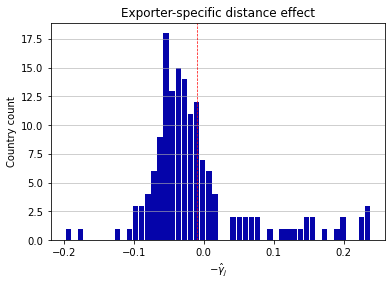

In [14]:
# histogram of heterogeneous effects
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_exp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_exp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{j}$')
plt.title('Exporter-specific distance effect')
plt.show()

In [15]:
print(np.round([np.mean(beta_exp[:,0]), marginal_effect_at_mean_exp, average_partial_effect_exp], 4))

[-0.0096 -0.0038 -0.0048]


*Note that these results do not exactly match that in the paper probably because of Jupyter's notebook rounding errors*.

### Estimate importer-specific effects

In [16]:
# estimate importer-specific distance effects 
from nlmfe.PanelPreProcess import PanelPreProcess
PanelPreProcess = PanelPreProcess()
data = data.sort_values(['impcode', 'expcode'])
Ximp, yimp, imp_ids, _ = PanelPreProcess.reshape_MaR(np.array(data)[:,:-1], np.array(data)[:,-1], 1, 0)

prob_mod = TwoWayFPMLE(Ximp, yimp, AFG, [0], model='probit')
beta_imp, alpha_imp, xi_imp = prob_mod.fit(fast=True, hess=True, iter_max=2)
marginal_effect_at_mean_imp = np.mean(beta_imp[:,0])*norm.pdf(np.nanmean(np.einsum('ijk,ik->ij', Ximp, beta_imp) 
                                + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))
average_partial_effect_imp = np.nanmean(beta_imp[:,0].reshape(len(imp_ids))[:,None]*norm.pdf(np.einsum('ijk,ik->ij', 
                                Ximp, beta_imp) + np.insert(alpha_imp, AFG, 0)[:,None] + xi_imp[None,:]))

Mixed heterogeneous and homogeneous slopes model.


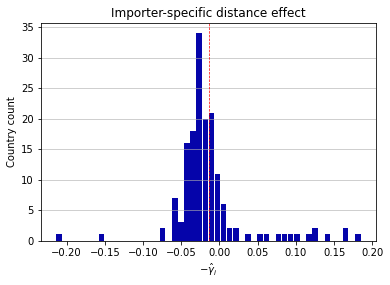

In [17]:
# histogram of heterogeneous effects
fig, ax = plt.subplots(figsize = (6,4))
plt.axvline(x=np.mean(beta_imp[:,0]), color='red', linestyle='--', linewidth=0.7)
plt.hist(beta_imp[:,0], bins=50, rwidth=0.9, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Country count')
plt.xlabel(r'$-\hat \gamma_{i}$')
plt.title('Importer-specific distance effect')
plt.show()

In [18]:
print(np.mean(beta_imp[:,0]))
print(marginal_effect_at_mean_imp)
print(average_partial_effect_imp)

-0.014346214817769576
-0.005708598291670141
-0.003932018561511836


*Again, these results do not match exactly that in the paper probably because of Jupyter's rounding errors.*

### Percentile bootstrap (symmetric) CIs for standard deviation

In [19]:
# compute percentile bootstrap (symmetric) CIs for standard deviation 
np.random.seed(2022) # replicability
B = 500
bs_samples_exp = np.random.choice(range(len(exp_ids)), size=(B, len(exp_ids)))
bs_samples_imp = np.random.choice(range(len(imp_ids)), size=(B, len(imp_ids)))
beta_res_exp = np.zeros((B, len(exp_ids), 1))
beta_res_imp = np.zeros((B, len(imp_ids), 1))

for b in tqdm(range(B)):
    prob_mod_exp = TwoWayFPMLE(Xexp[bs_samples_exp[b]], yexp[bs_samples_exp[b]], 0, [0], model='probit', verbose=False)
    beta_exp, _, _ = prob_mod_exp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_exp[b,:, 0] = beta_exp[:,0]
    prob_mod_imp = TwoWayFPMLE(Ximp[bs_samples_imp[b]], yimp[bs_samples_imp[b]], 0, [0], model='probit', verbose=False)
    beta_imp, _, _ = prob_mod_imp.fit(fast=True, hess=True, nu=1e-9, eps=1e-4, iter_max=2)
    beta_res_imp[b,:, 0] = beta_imp[:,0]

bs_std_exp = np.std(beta_res_exp, axis=1)
bs_std_imp = np.std(beta_res_imp, axis=1)
bs_std = np.concatenate((bs_std_exp, bs_std_imp), axis=1)

  0%|▏                                                                                 | 1/500 [00:00<01:02,  7.99it/s]

  1%|▍                                                                                 | 3/500 [00:00<01:06,  7.49it/s]

  1%|▋                                                                                 | 4/500 [00:00<01:05,  7.52it/s]

  1%|▉                                                                                 | 6/500 [00:00<01:09,  7.15it/s]

  2%|█▎                                                                                | 8/500 [00:01<01:06,  7.35it/s]

  2%|█▍                                                                                | 9/500 [00:01<01:05,  7.50it/s]

  2%|█▊                                                                               | 11/500 [00:01<01:03,  7.73it/s]

  3%|██                                                                               | 13/500 [00:01<01:07,  7.16it/s]

  3%|██▎                                                                              | 14/500 [00:01<01:17,  6.30it/s]

  3%|██▍                                                                              | 15/500 [00:02<01:15,  6.41it/s]C:\Users\MartinMUGNIER\Dropbox\2020_long_panel_two_way_fixed_effects\code\func.py:460: RuntimeWarning: divide by zero encountered in true_divide
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
C:\Users\MartinMUGNIER\Dropbox\2020_long_panel_two_way_fixed_effects\code\func.py:460: RuntimeWarning: invalid value encountered in multiply
  hess = A[:,:,:,None]*A[:,:,None,:] * (m**2/ (M*(1-M)))[:,:, None, None]
C:\Users\MartinMUGNIER\Dropbox\2020_long_panel_two_way_fixed_effects\code\func.py:260: RuntimeWarning: divide by zero encountered in true_divide
  grad = np.nansum(A * ((m/(M*(1-M))) * (b-M))[:,:,None], axis)
C:\Users\MartinMUGNIER\Dropbox\2020_long_panel_two_way_fixed_effects\code\func.py:260: RuntimeWarning: invalid value encountered in multiply
  grad = np.nansum(A * ((m/(M*(1-M))) * (b-M))[:,:,None], axis)
  3%|██▌                         

  4%|██▉                                                                              | 18/500 [00:02<01:09,  6.99it/s]

  4%|███▏                                                                             | 20/500 [00:02<01:07,  7.07it/s]

  4%|███▍                                                                             | 21/500 [00:02<01:08,  6.99it/s]

  5%|███▋                                                                             | 23/500 [00:03<01:07,  7.07it/s]

  5%|████                                                                             | 25/500 [00:03<01:04,  7.32it/s]

  5%|████▎                                                                            | 27/500 [00:03<01:06,  7.14it/s]

  6%|████▌                                                                            | 28/500 [00:03<01:07,  7.04it/s]

  6%|████▊                                                                            | 30/500 [00:04<01:07,  7.00it/s]

  6%|█████▏                                                                           | 32/500 [00:04<01:06,  7.02it/s]

  7%|█████▌                                                                           | 34/500 [00:04<01:09,  6.71it/s]

  7%|█████▋                                                                           | 35/500 [00:04<01:09,  6.70it/s]

  7%|█████▉                                                                           | 37/500 [00:05<01:08,  6.78it/s]

  8%|██████▏                                                                          | 38/500 [00:05<01:07,  6.89it/s]

  8%|██████▍                                                                          | 40/500 [00:05<01:07,  6.84it/s]

  8%|██████▋                                                                          | 41/500 [00:05<01:11,  6.46it/s]

  9%|██████▉                                                                          | 43/500 [00:06<01:08,  6.65it/s]

  9%|███████▎                                                                         | 45/500 [00:06<01:06,  6.83it/s]

  9%|███████▌                                                                         | 47/500 [00:06<01:04,  6.97it/s]

 10%|███████▊                                                                         | 48/500 [00:06<01:05,  6.93it/s]

 10%|███████▉                                                                         | 49/500 [00:07<01:04,  7.02it/s]

 10%|████████▎                                                                        | 51/500 [00:07<01:06,  6.77it/s]

 11%|████████▌                                                                        | 53/500 [00:07<01:02,  7.19it/s]

 11%|████████▉                                                                        | 55/500 [00:07<01:04,  6.90it/s]

 11%|█████████                                                                        | 56/500 [00:08<01:05,  6.82it/s]

 12%|█████████▍                                                                       | 58/500 [00:08<01:04,  6.82it/s]

 12%|█████████▋                                                                       | 60/500 [00:08<01:05,  6.75it/s]

 12%|██████████                                                                       | 62/500 [00:08<01:02,  6.96it/s]

 13%|██████████▏                                                                      | 63/500 [00:09<01:02,  7.04it/s]

 13%|██████████▎                                                                      | 64/500 [00:09<01:02,  6.98it/s]

 13%|██████████▋                                                                      | 66/500 [00:09<01:01,  7.02it/s]

 14%|███████████                                                                      | 68/500 [00:09<01:00,  7.14it/s]

 14%|███████████▎                                                                     | 70/500 [00:10<01:00,  7.15it/s]

 14%|███████████▌                                                                     | 71/500 [00:10<00:59,  7.21it/s]

 15%|███████████▊                                                                     | 73/500 [00:10<00:59,  7.20it/s]

 15%|████████████▏                                                                    | 75/500 [00:10<00:58,  7.31it/s]

 15%|████████████▎                                                                    | 76/500 [00:10<00:58,  7.26it/s]

 15%|████████████▍                                                                    | 77/500 [00:10<00:59,  7.13it/s]

 16%|████████████▊                                                                    | 79/500 [00:11<01:00,  6.96it/s]

 16%|█████████████                                                                    | 81/500 [00:11<00:58,  7.17it/s]

 16%|█████████████▎                                                                   | 82/500 [00:11<00:56,  7.35it/s]

 17%|█████████████▍                                                                   | 83/500 [00:11<00:58,  7.14it/s]

 17%|█████████████▊                                                                   | 85/500 [00:12<00:56,  7.28it/s]

 17%|█████████████▉                                                                   | 86/500 [00:12<00:57,  7.21it/s]

 18%|██████████████▎                                                                  | 88/500 [00:12<00:58,  7.03it/s]

 18%|██████████████▌                                                                  | 90/500 [00:12<00:57,  7.11it/s]

 18%|██████████████▋                                                                  | 91/500 [00:12<00:57,  7.14it/s]

 19%|███████████████                                                                  | 93/500 [00:13<00:56,  7.27it/s]

 19%|███████████████▍                                                                 | 95/500 [00:13<00:54,  7.37it/s]

 19%|███████████████▋                                                                 | 97/500 [00:13<00:55,  7.26it/s]

 20%|███████████████▉                                                                 | 98/500 [00:13<00:54,  7.39it/s]

 20%|████████████████                                                                 | 99/500 [00:14<00:54,  7.38it/s]

 20%|████████████████▏                                                               | 101/500 [00:14<00:54,  7.27it/s]

 21%|████████████████▍                                                               | 103/500 [00:14<00:52,  7.57it/s]

 21%|████████████████▋                                                               | 104/500 [00:14<00:53,  7.34it/s]

 21%|████████████████▊                                                               | 105/500 [00:14<00:55,  7.18it/s]

 21%|█████████████████                                                               | 107/500 [00:15<00:52,  7.50it/s]

 22%|█████████████████▍                                                              | 109/500 [00:15<00:51,  7.59it/s]

 22%|█████████████████▊                                                              | 111/500 [00:15<00:49,  7.82it/s]

 23%|██████████████████                                                              | 113/500 [00:15<00:48,  7.96it/s]

 23%|██████████████████▍                                                             | 115/500 [00:16<00:52,  7.38it/s]

 23%|██████████████████▌                                                             | 116/500 [00:16<00:52,  7.32it/s]

 24%|██████████████████▉                                                             | 118/500 [00:16<00:52,  7.21it/s]

 24%|███████████████████▏                                                            | 120/500 [00:16<00:51,  7.43it/s]

 24%|███████████████████▌                                                            | 122/500 [00:17<00:51,  7.40it/s]

 25%|███████████████████▋                                                            | 123/500 [00:17<00:49,  7.54it/s]

 25%|███████████████████▊                                                            | 124/500 [00:17<00:49,  7.61it/s]

 25%|████████████████████▏                                                           | 126/500 [00:17<00:51,  7.24it/s]

 25%|████████████████████▎                                                           | 127/500 [00:17<00:51,  7.26it/s]

 26%|████████████████████▋                                                           | 129/500 [00:18<00:50,  7.28it/s]

 26%|████████████████████▊                                                           | 130/500 [00:18<00:50,  7.35it/s]

 26%|█████████████████████                                                           | 132/500 [00:18<00:50,  7.25it/s]

 27%|█████████████████████▍                                                          | 134/500 [00:18<00:49,  7.41it/s]

 27%|█████████████████████▊                                                          | 136/500 [00:19<00:49,  7.42it/s]

 27%|█████████████████████▉                                                          | 137/500 [00:19<00:49,  7.35it/s]

 28%|██████████████████████▏                                                         | 139/500 [00:19<00:47,  7.64it/s]

 28%|██████████████████████▍                                                         | 140/500 [00:19<00:46,  7.71it/s]

 28%|██████████████████████▋                                                         | 142/500 [00:19<00:48,  7.41it/s]

 29%|███████████████████████                                                         | 144/500 [00:20<00:47,  7.53it/s]

 29%|███████████████████████▎                                                        | 146/500 [00:20<00:46,  7.67it/s]

 30%|███████████████████████▋                                                        | 148/500 [00:20<00:48,  7.32it/s]

 30%|███████████████████████▊                                                        | 149/500 [00:20<00:49,  7.11it/s]

 30%|████████████████████████                                                        | 150/500 [00:20<00:49,  7.10it/s]

 30%|████████████████████████▎                                                       | 152/500 [00:21<00:48,  7.14it/s]

 31%|████████████████████████▍                                                       | 153/500 [00:21<00:49,  6.99it/s]

 31%|████████████████████████▊                                                       | 155/500 [00:21<00:47,  7.33it/s]

 31%|█████████████████████████                                                       | 157/500 [00:21<00:47,  7.21it/s]

 32%|█████████████████████████▎                                                      | 158/500 [00:22<00:48,  7.08it/s]

 32%|█████████████████████████▌                                                      | 160/500 [00:22<00:48,  7.07it/s]

 32%|█████████████████████████▊                                                      | 161/500 [00:22<00:46,  7.22it/s]

 33%|██████████████████████████                                                      | 163/500 [00:22<00:45,  7.42it/s]

 33%|██████████████████████████▍                                                     | 165/500 [00:23<00:46,  7.27it/s]

 33%|██████████████████████████▌                                                     | 166/500 [00:23<00:45,  7.36it/s]

 33%|██████████████████████████▋                                                     | 167/500 [00:23<00:45,  7.39it/s]

 34%|███████████████████████████                                                     | 169/500 [00:23<00:44,  7.49it/s]

 34%|███████████████████████████▎                                                    | 171/500 [00:23<00:45,  7.29it/s]

 34%|███████████████████████████▌                                                    | 172/500 [00:23<00:42,  7.65it/s]

 35%|███████████████████████████▋                                                    | 173/500 [00:24<00:42,  7.62it/s]

 35%|████████████████████████████                                                    | 175/500 [00:24<00:45,  7.20it/s]

 35%|████████████████████████████▏                                                   | 176/500 [00:24<00:43,  7.37it/s]

 36%|████████████████████████████▍                                                   | 178/500 [00:24<00:43,  7.33it/s]

 36%|████████████████████████████▊                                                   | 180/500 [00:25<00:46,  6.92it/s]

 36%|█████████████████████████████                                                   | 182/500 [00:25<00:42,  7.45it/s]

 37%|█████████████████████████████▎                                                  | 183/500 [00:25<00:41,  7.61it/s]

 37%|█████████████████████████████▌                                                  | 185/500 [00:25<00:42,  7.47it/s]

 37%|█████████████████████████████▊                                                  | 186/500 [00:25<00:41,  7.65it/s]

 38%|██████████████████████████████                                                  | 188/500 [00:26<00:40,  7.73it/s]

 38%|██████████████████████████████▍                                                 | 190/500 [00:26<00:42,  7.23it/s]

 38%|██████████████████████████████▌                                                 | 191/500 [00:26<00:42,  7.25it/s]

 39%|██████████████████████████████▉                                                 | 193/500 [00:26<00:41,  7.33it/s]

 39%|███████████████████████████████▏                                                | 195/500 [00:27<00:41,  7.33it/s]

 39%|███████████████████████████████▌                                                | 197/500 [00:27<00:39,  7.72it/s]

 40%|███████████████████████████████▋                                                | 198/500 [00:27<00:43,  6.91it/s]

 40%|████████████████████████████████                                                | 200/500 [00:27<00:43,  6.93it/s]

 40%|████████████████████████████████▎                                               | 202/500 [00:28<00:41,  7.15it/s]

 41%|████████████████████████████████▍                                               | 203/500 [00:28<00:42,  7.00it/s]

 41%|████████████████████████████████▊                                               | 205/500 [00:28<00:40,  7.34it/s]

 41%|████████████████████████████████▉                                               | 206/500 [00:28<00:41,  7.16it/s]

 42%|█████████████████████████████████▎                                              | 208/500 [00:28<00:39,  7.32it/s]

 42%|█████████████████████████████████▌                                              | 210/500 [00:29<00:39,  7.44it/s]

 42%|█████████████████████████████████▉                                              | 212/500 [00:29<00:37,  7.61it/s]

 43%|██████████████████████████████████▏                                             | 214/500 [00:29<00:38,  7.37it/s]

 43%|██████████████████████████████████▍                                             | 215/500 [00:29<00:39,  7.20it/s]

 43%|██████████████████████████████████▋                                             | 217/500 [00:30<00:40,  6.93it/s]

 44%|███████████████████████████████████                                             | 219/500 [00:30<00:38,  7.21it/s]

 44%|███████████████████████████████████▏                                            | 220/500 [00:30<00:44,  6.25it/s]

 44%|███████████████████████████████████▎                                            | 221/500 [00:30<00:47,  5.81it/s]

 45%|███████████████████████████████████▋                                            | 223/500 [00:31<00:44,  6.29it/s]

 45%|███████████████████████████████████▊                                            | 224/500 [00:31<00:44,  6.21it/s]

 45%|████████████████████████████████████▏                                           | 226/500 [00:31<00:41,  6.68it/s]

 46%|████████████████████████████████████▍                                           | 228/500 [00:31<00:40,  6.64it/s]

 46%|████████████████████████████████████▋                                           | 229/500 [00:32<00:41,  6.49it/s]

 46%|████████████████████████████████████▉                                           | 231/500 [00:32<00:40,  6.71it/s]

 46%|█████████████████████████████████████                                           | 232/500 [00:32<00:39,  6.78it/s]

 47%|█████████████████████████████████████▍                                          | 234/500 [00:32<00:39,  6.69it/s]

 47%|█████████████████████████████████████▊                                          | 236/500 [00:33<00:37,  6.99it/s]

 47%|█████████████████████████████████████▉                                          | 237/500 [00:33<00:36,  7.20it/s]

 48%|██████████████████████████████████████▏                                         | 239/500 [00:33<00:37,  7.01it/s]

 48%|██████████████████████████████████████▌                                         | 241/500 [00:33<00:36,  7.17it/s]

 48%|██████████████████████████████████████▋                                         | 242/500 [00:33<00:36,  7.11it/s]

 49%|██████████████████████████████████████▉                                         | 243/500 [00:34<00:36,  7.13it/s]

 49%|███████████████████████████████████████▏                                        | 245/500 [00:34<00:36,  6.97it/s]

 49%|███████████████████████████████████████▎                                        | 246/500 [00:34<00:35,  7.12it/s]

 50%|███████████████████████████████████████▋                                        | 248/500 [00:34<00:35,  7.15it/s]

 50%|████████████████████████████████████████                                        | 250/500 [00:35<00:37,  6.66it/s]

 50%|████████████████████████████████████████▏                                       | 251/500 [00:35<00:36,  6.75it/s]

 51%|████████████████████████████████████████▍                                       | 253/500 [00:35<00:35,  7.01it/s]

 51%|████████████████████████████████████████▊                                       | 255/500 [00:35<00:34,  7.05it/s]

 51%|████████████████████████████████████████▉                                       | 256/500 [00:35<00:35,  6.91it/s]

 52%|█████████████████████████████████████████▎                                      | 258/500 [00:36<00:36,  6.60it/s]

 52%|█████████████████████████████████████████▍                                      | 259/500 [00:36<00:35,  6.73it/s]

 52%|█████████████████████████████████████████▊                                      | 261/500 [00:36<00:34,  7.03it/s]

 52%|█████████████████████████████████████████▉                                      | 262/500 [00:36<00:33,  7.00it/s]

 53%|██████████████████████████████████████████▏                                     | 264/500 [00:37<00:33,  7.01it/s]

 53%|██████████████████████████████████████████▌                                     | 266/500 [00:37<00:33,  7.05it/s]

 53%|██████████████████████████████████████████▋                                     | 267/500 [00:37<00:32,  7.11it/s]

 54%|███████████████████████████████████████████                                     | 269/500 [00:37<00:34,  6.73it/s]

 54%|███████████████████████████████████████████▎                                    | 271/500 [00:38<00:33,  6.80it/s]

 54%|███████████████████████████████████████████▌                                    | 272/500 [00:38<00:32,  6.99it/s]

 55%|███████████████████████████████████████████▊                                    | 274/500 [00:38<00:32,  7.05it/s]

 55%|████████████████████████████████████████████▏                                   | 276/500 [00:38<00:30,  7.30it/s]

 55%|████████████████████████████████████████████▎                                   | 277/500 [00:38<00:29,  7.62it/s]

 56%|████████████████████████████████████████████▋                                   | 279/500 [00:39<00:30,  7.29it/s]

 56%|████████████████████████████████████████████▊                                   | 280/500 [00:39<00:30,  7.14it/s]

 56%|█████████████████████████████████████████████                                   | 282/500 [00:39<00:29,  7.38it/s]

 57%|█████████████████████████████████████████████▎                                  | 283/500 [00:39<00:29,  7.24it/s]

 57%|█████████████████████████████████████████████▌                                  | 285/500 [00:39<00:30,  7.04it/s]

 57%|█████████████████████████████████████████████▉                                  | 287/500 [00:40<00:27,  7.61it/s]

 58%|██████████████████████████████████████████████                                  | 288/500 [00:40<00:27,  7.72it/s]

 58%|██████████████████████████████████████████████▍                                 | 290/500 [00:40<00:26,  7.86it/s]

 58%|██████████████████████████████████████████████▋                                 | 292/500 [00:40<00:26,  7.94it/s]

 59%|███████████████████████████████████████████████                                 | 294/500 [00:41<00:26,  7.85it/s]

 59%|███████████████████████████████████████████████▎                                | 296/500 [00:41<00:25,  7.97it/s]

 59%|███████████████████████████████████████████████▌                                | 297/500 [00:41<00:26,  7.59it/s]

 60%|███████████████████████████████████████████████▊                                | 299/500 [00:41<00:25,  7.81it/s]

 60%|████████████████████████████████████████████████▏                               | 301/500 [00:42<00:25,  7.86it/s]

 61%|████████████████████████████████████████████████▍                               | 303/500 [00:42<00:24,  8.08it/s]

 61%|████████████████████████████████████████████████▊                               | 305/500 [00:42<00:24,  7.94it/s]

 61%|█████████████████████████████████████████████████                               | 307/500 [00:42<00:25,  7.69it/s]

 62%|█████████████████████████████████████████████████▍                              | 309/500 [00:43<00:24,  7.76it/s]

 62%|█████████████████████████████████████████████████▊                              | 311/500 [00:43<00:25,  7.53it/s]

 63%|██████████████████████████████████████████████████                              | 313/500 [00:43<00:24,  7.73it/s]

 63%|██████████████████████████████████████████████████▏                             | 314/500 [00:43<00:24,  7.74it/s]

 63%|██████████████████████████████████████████████████▌                             | 316/500 [00:43<00:23,  7.80it/s]

 63%|██████████████████████████████████████████████████▋                             | 317/500 [00:44<00:24,  7.54it/s]

 64%|███████████████████████████████████████████████████                             | 319/500 [00:44<00:24,  7.47it/s]

 64%|███████████████████████████████████████████████████▏                            | 320/500 [00:44<00:24,  7.34it/s]

 64%|███████████████████████████████████████████████████▌                            | 322/500 [00:44<00:23,  7.73it/s]

 65%|███████████████████████████████████████████████████▊                            | 324/500 [00:44<00:22,  7.70it/s]

 65%|████████████████████████████████████████████████████                            | 325/500 [00:45<00:23,  7.46it/s]

 65%|████████████████████████████████████████████████████▎                           | 327/500 [00:45<00:22,  7.86it/s]

 66%|████████████████████████████████████████████████████▋                           | 329/500 [00:45<00:22,  7.63it/s]

 66%|████████████████████████████████████████████████████▊                           | 330/500 [00:45<00:22,  7.43it/s]

 66%|█████████████████████████████████████████████████████                           | 332/500 [00:46<00:23,  7.12it/s]

 67%|█████████████████████████████████████████████████████▍                          | 334/500 [00:46<00:22,  7.43it/s]

 67%|█████████████████████████████████████████████████████▌                          | 335/500 [00:46<00:21,  7.53it/s]

 67%|█████████████████████████████████████████████████████▊                          | 336/500 [00:46<00:21,  7.55it/s]

 68%|██████████████████████████████████████████████████████                          | 338/500 [00:46<00:21,  7.41it/s]

 68%|██████████████████████████████████████████████████████▍                         | 340/500 [00:47<00:21,  7.30it/s]

 68%|██████████████████████████████████████████████████████▌                         | 341/500 [00:47<00:21,  7.39it/s]

 68%|██████████████████████████████████████████████████████▋                         | 342/500 [00:47<00:21,  7.22it/s]

 69%|███████████████████████████████████████████████████████                         | 344/500 [00:47<00:27,  5.62it/s]

 69%|███████████████████████████████████████████████████████▏                        | 345/500 [00:48<00:28,  5.45it/s]

 69%|███████████████████████████████████████████████████████▎                        | 346/500 [00:48<00:28,  5.42it/s]

 69%|███████████████████████████████████████████████████████▌                        | 347/500 [00:48<00:26,  5.77it/s]

 70%|███████████████████████████████████████████████████████▋                        | 348/500 [00:48<00:24,  6.10it/s]

 70%|████████████████████████████████████████████████████████                        | 350/500 [00:48<00:21,  6.84it/s]

 70%|████████████████████████████████████████████████████████▎                       | 352/500 [00:49<00:22,  6.47it/s]

 71%|████████████████████████████████████████████████████████▍                       | 353/500 [00:49<00:23,  6.17it/s]

 71%|████████████████████████████████████████████████████████▊                       | 355/500 [00:49<00:23,  6.17it/s]

 71%|█████████████████████████████████████████████████████████                       | 357/500 [00:49<00:22,  6.42it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [00:50<00:22,  6.28it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [00:50<00:21,  6.54it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [00:50<00:22,  6.28it/s]

 73%|██████████████████████████████████████████████████████████                      | 363/500 [00:50<00:21,  6.26it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [00:51<00:21,  6.28it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [00:51<00:19,  6.75it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [00:51<00:18,  7.25it/s]

 74%|███████████████████████████████████████████████████████████                     | 369/500 [00:51<00:20,  6.37it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [00:52<00:20,  6.24it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [00:52<00:19,  6.51it/s]

 75%|████████████████████████████████████████████████████████████                    | 375/500 [00:52<00:22,  5.66it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [00:52<00:21,  5.65it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [00:53<00:21,  5.85it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [00:53<00:20,  5.88it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [00:53<00:19,  6.06it/s]

 76%|█████████████████████████████████████████████████████████████                   | 382/500 [00:53<00:18,  6.27it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [00:54<00:16,  6.85it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [00:54<00:16,  6.95it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [00:54<00:17,  6.68it/s]

 78%|██████████████████████████████████████████████████████████████                  | 388/500 [00:54<00:16,  6.60it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [00:54<00:17,  6.45it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [00:55<00:16,  6.64it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [00:55<00:15,  6.98it/s]

 79%|███████████████████████████████████████████████████████████████                 | 394/500 [00:55<00:14,  7.08it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [00:56<00:16,  6.37it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [00:56<00:15,  6.74it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [00:56<00:15,  6.69it/s]

 80%|████████████████████████████████████████████████████████████████                | 400/500 [00:56<00:15,  6.66it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [00:56<00:14,  6.63it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [00:57<00:14,  6.67it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [00:57<00:14,  6.63it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [00:57<00:14,  6.55it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [00:57<00:15,  6.06it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [00:58<00:15,  5.91it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [00:58<00:14,  6.01it/s]

 83%|██████████████████████████████████████████████████████████████████              | 413/500 [00:58<00:12,  6.79it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [00:58<00:12,  7.01it/s]

 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [00:59<00:11,  7.13it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [00:59<00:11,  7.14it/s]

 84%|███████████████████████████████████████████████████████████████████             | 419/500 [00:59<00:11,  7.33it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [00:59<00:10,  7.42it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [00:59<00:10,  7.48it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [00:59<00:10,  7.69it/s]

 85%|████████████████████████████████████████████████████████████████████            | 425/500 [01:00<00:09,  7.61it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [01:00<00:09,  7.57it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [01:00<00:09,  7.53it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [01:00<00:09,  7.54it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [01:01<00:09,  7.16it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [01:01<00:09,  6.93it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [01:01<00:09,  6.79it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [01:01<00:08,  7.07it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [01:02<00:08,  7.25it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [01:02<00:08,  7.43it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [01:02<00:07,  7.47it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [01:02<00:07,  7.74it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [01:02<00:07,  7.63it/s]

 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [01:03<00:07,  7.34it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [01:03<00:07,  7.32it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [01:03<00:06,  7.43it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [01:03<00:06,  7.44it/s]

 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [01:04<00:06,  7.07it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [01:04<00:06,  6.47it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [01:04<00:06,  6.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [01:04<00:06,  6.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [01:04<00:05,  7.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [01:05<00:06,  6.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [01:05<00:05,  6.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [01:05<00:05,  6.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [01:05<00:05,  6.49it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [01:06<00:05,  6.34it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [01:06<00:05,  6.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [01:06<00:04,  6.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [01:06<00:04,  6.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [01:07<00:04,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [01:07<00:04,  5.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [01:07<00:04,  5.73it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [01:07<00:03,  5.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [01:08<00:03,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [01:08<00:03,  5.79it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [01:08<00:03,  5.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [01:08<00:02,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [01:09<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [01:09<00:02,  5.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [01:09<00:02,  5.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [01:09<00:01,  5.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [01:10<00:01,  6.02it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [01:10<00:01,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [01:10<00:01,  5.91it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [01:10<00:00,  5.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [01:11<00:00,  5.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [01:11<00:00,  5.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:11<00:00,  6.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  6.96it/s]


In [20]:
# CI for standard deviation
print('exporter-specific', 'importer-specific')
print('lower ends: ', np.quantile(bs_std, 0.025, axis=0))
print('upper ends: ', np.quantile(bs_std, 0.975, axis=0))

exporter-specific importer-specific
lower ends:  [0.06562919 0.03635777]
upper ends:  [0.09149921 0.06108626]


## References

- Fernández-Val, I., and M. Weidner (2016): “Individual and time effects in nonlinear panel models with large N, T”, *Journal of Econometrics*, 192(1), 291–312.

- Helpman, E., M. Melitz, and Y. Rubinstein (2008): “Estimating trade flows: Trading partners and trading volumes”, *The Quarterly Journal of Economics*, 123(2), 441–487.
